In [1]:
import os
import numpy as np 
import time


from sklearn.model_selection import KFold  # 라벨 x_data, y_data 분포를 유지 (함께 fold)
from IPython.display import clear_output

homeDir = "/DockerProjects/walkCAM/tug/temporalCNN_wLabel"
os.chdir(homeDir); print(" [Home Dir.] Current path", os.getcwd())  


from TCN_v1_Lib.preprocessing import preprocess
from TCN_v1_Lib.plot_graph import plotGragh


np.random.seed(7)
np.set_printoptions(precision=4, suppress=True)  # 과학적 표기 대신 소숫점 자리 4자리까지 표현


selected_LPF = "LPF_C3_5_O4"  # LPF_C3_5_O4
rootDir = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper" + "/" + selected_LPF
# expertFolder = "/" + "LSTM2HMM_saveResults_illness_KHJ"  # --- 변경 할 부분
expertFolder = "/" + "LSTM2HMM_saveResults_illness_KYH"  # --- 변경 할 부분
viewFolder = "/" + "0_sideView"

datasetDir = rootDir + expertFolder + viewFolder
os.chdir(datasetDir) ; print(" Current workaing path [dataset] ", os.getcwd())  # -- Dataset 있는 곳으로 경로 변경 


utils = preprocess(datasetDir, expertFolder)
plot = plotGragh(actSplit=True, save=False)

 [Home Dir.] Current path /DockerProjects/walkCAM/tug/temporalCNN_wLabel
 Current workaing path [dataset]  /DockerProjects/Dataset/TUG/trainSet/HMMpaper/LPF_C3_5_O4/LSTM2HMM_saveResults_illness_KYH/0_sideView


## Create Dataset 
#### - Choose specific group (norm 20, norm60, stroke... or K-fold)

In [20]:
train_ratio = 0.6
valid_ratio = 0.2

shuffle = True
arbitrarySplit = True
Kfold = False
Kfold_num = 5 


selected_type = "norm60"
selected_subjects = next(os.walk(os.path.join(datasetDir,selected_type )))[1]
numOfsubjects = len( selected_subjects )


specific_group = selected_subjects
print(" selected Group: {0} \t, # of Subjects: {1} \n --> subject list: {2}".format( selected_type, numOfsubjects, selected_subjects))

if Kfold:

    print(" K-fold : ", Kfold_num)
    trainFold, testFold = utils.fold_trainNames(subList = specific_group, Kfold_num = Kfold_num)
        
else:
    np.random.shuffle(specific_group)
    
    trainSub_number = np.round( (numOfsubjects*train_ratio), 0).astype(int)
    validSub_number = np.round( (numOfsubjects*valid_ratio), 0).astype(int)
    testSub_number = numOfsubjects - trainSub_number - validSub_number

    train_subjects = specific_group[ :trainSub_number]
    valid_subjects = specific_group[ trainSub_number : (trainSub_number + validSub_number)]
    test_subjects = specific_group[ (trainSub_number+validSub_number): ]
    
    print(" No-fold --- (arbitrary) \t [results] \n\t Train 명: " ,len(train_subjects), "\n\t Valid 명: ", len(valid_subjects), "\n\t Test 명: ", len(test_subjects))
    print(" No-fold --- (arbitrary) \t [results] \n\t Train: " ,train_subjects, "\n\t Valid: ", valid_subjects, "\n\t Test: ", test_subjects)
    

 selected Group: norm60 	, # of Subjects: 24 
 --> subject list: ['KYS3_TUG', 'YSS2_TUG', 'SJJ_TUG', 'HOJ_TUG', 'LJE_TUG', 'LJS_TUG', 'GYH_TUG', 'KJK_TUG', 'UMS_TUG', 'JJS_TUG', 'KHM_TUG', 'NHJ_60', 'LBL_TUG', 'SOS_TUG', 'BKS_TUG', 'HSN_TUG', 'CSY_TUG', 'rjh', 'LKO_TUG', 'LSS_TUG', 'PSM_TUG', 'PBK_TUG', 'KBH_TUG', 'LSC_TUG']
 No-fold --- (arbitrary) 	 [results] 
	 Train 명:  14 
	 Valid 명:  5 
	 Test 명:  5
 No-fold --- (arbitrary) 	 [results] 
	 Train:  ['PSM_TUG', 'LKO_TUG', 'SOS_TUG', 'PBK_TUG', 'YSS2_TUG', 'KHM_TUG', 'HSN_TUG', 'rjh', 'LSC_TUG', 'HOJ_TUG', 'KJK_TUG', 'BKS_TUG', 'LJE_TUG', 'KBH_TUG'] 
	 Valid:  ['JJS_TUG', 'UMS_TUG', 'SJJ_TUG', 'KYS3_TUG', 'CSY_TUG'] 
	 Test:  ['LJS_TUG', 'LBL_TUG', 'LSS_TUG', 'GYH_TUG', 'NHJ_60']


In [21]:
utils.lookback_window = 8

# total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y =  utils.readRaw_createDataset(specific_group, train_subjects, test_subjects, lookback_window = lookback_window)
total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y =  utils.readLPF_createDataset(specific_group, train_subjects, test_subjects, Kfold)
print("train_x: ", train_x.shape," , train_y: ", train_y.shape)
print("valid_x: ",valid_x.shape, " , valid_y: ",valid_y.shape)
print("test_x: ",test_x.shape, "  , test_y: ",test_y.shape)

train_x:  (114574, 8, 3, 1)  , train_y:  (114574, 5)
valid_x:  (35762, 8, 3, 1)  , valid_y:  (35762, 5)
test_x:  (37924, 8, 3, 1)   , test_y:  (37924, 5)


### Model Build

In [22]:
import tensorflow as tf
from keras.layers import Conv1D, Input, Activation, Flatten, Dense, Conv2D
from keras.layers import BatchNormalization, add , Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tcn import TCN

In [23]:
 #Residual block :: https://roadcom.tistory.com/95
def ResBlock(x,filters,kernel_size,dilation_rate):
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate,activation='relu')(x) #first convolution
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate)(r) #Second convolution
    if x.shape[-1]==filters:
        # Shortcut 의 channel 과 main path 의 channel 이 일치할 경우 단순 add 연산만 진행하는 블록 = identity block
        shortcut = x  # identity block 
    else: 
        # Shortcut 의 channel 과 main path 의 channel 이 다를 경우 shortcut path 를 적절히 변환
        # 즉, projection 을 통해 channel 을 맞춰주는 작업이(projection shortcut) 추가되기에 이를 convolution block 이라함
        shortcut=Conv2D(filters,kernel_size=kernel_size,padding='same')(x) 
    o=add([r,shortcut])
    o=Activation('relu')(o) 
    return o
 
 #Sequence Model
def TCN(optimizer='adam'):
    kernel_size = (3,3)
    input_shape =  (utils.lookback_window, 3, 1) # (8,3, 1) = (feature, sliding_window, 1)
    
    inputs=Input(shape=input_shape)
    
    x=ResBlock(x = inputs,filters=32,kernel_size=kernel_size,dilation_rate=1)
    x = Dropout(0.2) (x)
    x=ResBlock(x,filters=32,kernel_size=kernel_size,dilation_rate=2)
    x = Dropout(0.4)(x)
    x=ResBlock(x,filters=16,kernel_size=kernel_size,dilation_rate=4)
    
    x=Flatten()(x)
    x=Dense(utils.numActions, activation='softmax')(x)
    model=Model(inputs=inputs,outputs=x)
         
    model.summary()
        
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
 
    return model

In [24]:
class_weight = {0:0.303, 1:1.0, 2: 0.144, 3:0.487, 4: 0.7}
# class_weight = {0:1. , 1:3.3, 2: 0.4752, 3:1.6071, 4: 2.31} #  x 0.303 기준으로 다 배수  

batch_size = 512
epochs = 100000

learning_rate = 0.00007
patience = 15

In [25]:
ModelTime =  time.strftime('%Y%m%d-%Hh%Mm', time.localtime(time.time()))
MODEL_SAVE_FOLDER_PATH ="/DockerProjects/walkCAM/tug/temporalCNN_wLabel/Results/" + selected_LPF + expertFolder +"/" + str(selected_type) +"_P" +str(patience)+"_" + ModelTime +  "/Model" 

print(MODEL_SAVE_FOLDER_PATH)
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.makedirs(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + "-"+ selected_type +"-lr:"+ str(learning_rate) +"-p:" +str(patience)+ "_{epoch:04d} -- {val_loss:.4f}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", verbose=1, save_best_only=True)
cb_early_stopping = EarlyStopping(monitor="val_loss", patience=patience)

/DockerProjects/walkCAM/tug/temporalCNN_wLabel/Results/LPF_C3_5_O4/LSTM2HMM_saveResults_illness_KYH/norm60_P15_20210516-20h12m/Model


In [26]:

optimizer = tf.optimizers.Adam(learning_rate)

model = TCN(optimizer)
model.save(MODEL_SAVE_FOLDER_PATH+"/Origin_TCN_model")
hist = model.fit(train_x,train_y, batch_size= batch_size, epochs=epochs,verbose=2, validation_data= (valid_x, valid_y),   callbacks=[cb_checkpoint, cb_early_stopping], class_weight=class_weight)
eval_result = model.evaluate(test_x, test_y,batch_size= batch_size,verbose=2)

print('test_loss:',eval_result[0],'- test_acc:',eval_result[1])

reportd_subjects = open(MODEL_SAVE_FOLDER_PATH + "/" + str(selected_type)+ "_subjectLists" ".txt",'w+t')
    

print("[Train subjects]\n\t", train_subjects , file =reportd_subjects )
print("[Test subjects]\n\t", test_subjects , file =reportd_subjects )
print('test_loss:',eval_result[0],'- test_acc:',eval_result[1], file =reportd_subjects)
reportd_subjects.close()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8, 3, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 8, 3, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 8, 3, 32)     9248        conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 8, 3, 32)     320         input_2[0][0]                    
____________________________________________________________________________________________

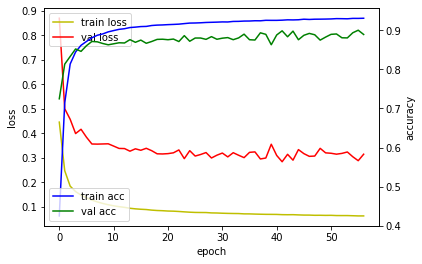

In [27]:
import matplotlib.pyplot as plt


fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.savefig(MODEL_SAVE_FOLDER_PATH+"/lr_"+str(learning_rate)+"_patience_"+ str(patience)+"_Loss_"+str(np.round(eval_result[1],4))+".png")
plt.show()


In [28]:
def action_frames(y_pred_argmax, ratio_display = False):
    action_label =  {"sit": 0, "sit-stand": 1,  "walk": 2, "turn": 3,  "stand-sit": 4}
    action_cnt =  {"total_frames": 0,"sit": 0, "sit-stand": 0,  "walk": 0, "turn": 0,"stand-sit": 0}

    for i in range(len(y_pred_argmax)):
        action_cnt["total_frames"] +=1
        if y_pred_argmax[i] == action_label["sit"]:
            action_cnt["sit"] +=1
            
        elif y_pred_argmax[i] == action_label["sit-stand"]:
            action_cnt["sit-stand"] +=1
            
        elif y_pred_argmax[i] == action_label["walk"]:
            action_cnt["walk"] +=1
            
        elif y_pred_argmax[i] == action_label["turn"]:
            action_cnt["turn"] +=1
        
            
        elif y_pred_argmax[i] == action_label["stand-sit"]:
            action_cnt["stand-sit"] +=1
        
    if ratio_display:     
        print("[ Action Ratio ]")
        print("\t [ 0 - Sit] ratio of sit: ",  action_cnt["sit"]/action_cnt["total_frames"] )
        print("\t [ 1 - sit-stand] ratio of sit-stand: ",  action_cnt["sit-stand"]/action_cnt["total_frames"])
        print("\t [ 2 - walk] ratio of walk: ",  action_cnt["walk"]/action_cnt["total_frames"])
        print("\t [ 3 - turn] ratio of turn: ",  action_cnt["turn"]/action_cnt["total_frames"])
        print("\t [ 4 - stand-sit] ratio of stand-sit: ",  action_cnt["stand-sit"]/action_cnt["total_frames"])
    return action_cnt
    
    
    
y_pred = model.predict(test_x)
y_pred_onehot = np.argmax(y_pred, axis=1)
print(y_pred.shape)
print(y_pred[200] ,"===> onehot: ", y_pred_onehot[200])

y_test_argmax = np.argmax(test_y ,axis=1) 
y_pred_argmax = np.argmax(y_pred ,axis=1)
print(y_test_argmax.shape, y_pred_argmax.shape)


y_pred_frames = action_frames(y_pred_argmax, ratio_display= True)
y_test_frames = action_frames(y_test_argmax,  ratio_display= True)   

print("--->  # of Each Action Frames  \n\t y_pred: {0}, \n\t y_test: {1}".format(y_pred_frames, y_test_frames))

(37924, 5)
[0.     0.     0.0007 0.9993 0.    ] ===> onehot:  3
(37924,) (37924,)
[ Action Ratio ]
	 [ 0 - Sit] ratio of sit:  0.26645396055268433
	 [ 1 - sit-stand] ratio of sit-stand:  0.08722708575044827
	 [ 2 - walk] ratio of walk:  0.43138909397742853
	 [ 3 - turn] ratio of turn:  0.13284463664170446
	 [ 4 - stand-sit] ratio of stand-sit:  0.08208522307773441
[ Action Ratio ]
	 [ 0 - Sit] ratio of sit:  0.2837253454276975
	 [ 1 - sit-stand] ratio of sit-stand:  0.07029849172028267
	 [ 2 - walk] ratio of walk:  0.44768484337095243
	 [ 3 - turn] ratio of turn:  0.12841472418521252
	 [ 4 - stand-sit] ratio of stand-sit:  0.06987659529585487
--->  # of Each Action Frames  
	 y_pred: {'total_frames': 37924, 'sit': 10105, 'sit-stand': 3308, 'walk': 16360, 'turn': 5038, 'stand-sit': 3113}, 
	 y_test: {'total_frames': 37924, 'sit': 10760, 'sit-stand': 2666, 'walk': 16978, 'turn': 4870, 'stand-sit': 2650}


Cohens kappa: 0.895441
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     10760
           1       0.73      0.91      0.81      2666
           2       0.97      0.94      0.95     16978
           3       0.90      0.93      0.91      4870
           4       0.79      0.92      0.85      2650

    accuracy                           0.93     37924
   macro avg       0.87      0.92      0.89     37924
weighted avg       0.93      0.93      0.93     37924


---> Confusion Matrix 
 [[ 9865   533     0     0   362]
 [  193  2425     4     0    44]
 [    0   316 15883   523   256]
 [    0     0   355  4515     0]
 [   47    34   118     0  2451]]


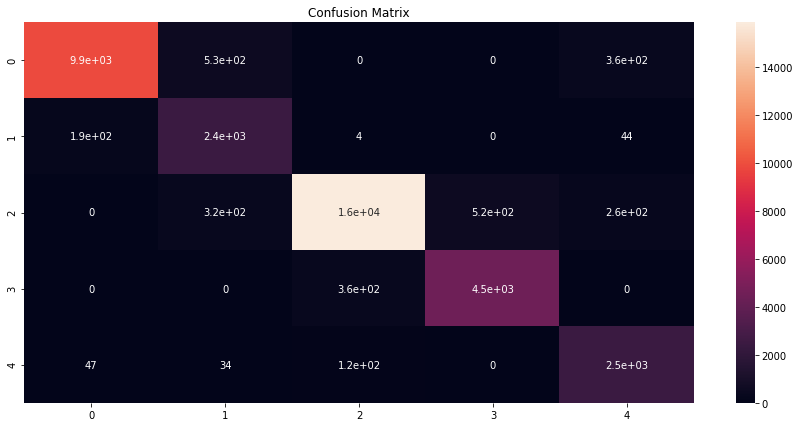

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import seaborn as sns


kappa = cohen_kappa_score(y_test_argmax, y_pred_argmax)
print('Cohens kappa: %f' % kappa)

print(classification_report(y_test_argmax, y_pred_argmax))
conf_matrix = confusion_matrix(y_test_argmax, y_pred_argmax)
print("\n---> Confusion Matrix \n" ,conf_matrix) # sit, sit-stand, walking, turning, stand-sit

plt.figure(figsize = (15,7) )
sns.heatmap(conf_matrix, annot=True)
plt.title("Confusion Matrix")
plt.savefig(MODEL_SAVE_FOLDER_PATH+"/pred_Confusion_Matrix.png")
plt.show()

## POST processing (DTW) 

In [30]:
from dtw import dtw
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

act_dict = {"sit":0, "sit-to-stand":1, "walk": 2, "turn": 3, "stand-to-sit":4}
answer_y = [act_dict["sit"], act_dict["sit-to-stand"], act_dict["walk"], act_dict["turn"], act_dict["walk"], act_dict["stand-to-sit"], act_dict["sit"] ]
target_names = ["sit", "sit-to-stand", "walk", "turn", "stand-to-sit"]


def post_process_DTW(time_sec, test_y, pred_y, answer_y, title = "normal_20"):
    dtw_index ={"walk":4, "stand-to-sit": 5, "sit": 6}
    dtw_alignment  = dtw(pred_y,answer_y, keep_internals=True)
    
    pred_subTask_sec = np.zeros(5)
    true_subTask_sec = np.zeros(5)
    
    pred_subTask_frame = np.zeros(5, np.uint64)
    true_subTask_frame = np.zeros(5, np.uint64)

    report_time= open(MODEL_SAVE_FOLDER_PATH + "/Report_frameSplit_Results_" + str( title)  +".txt",'w+t')
    # ----------- Time split ... Frame Index
    pred_splitFrame =  np.where( np.abs(dtw_alignment.index2[1:]-dtw_alignment.index2[:-1] ) > 0)[0] 
    true_splitFrame = np.where( np.abs(test_y[1:]-test_y[:-1] ) > 0)[0] + 8 # lookback_window

    print("\npred_splitFrame: {0} \n--> true_splitFrame: {1}".format(pred_splitFrame,true_splitFrame), file = report_time)
    
    for i in range(5):
        pred_subTask_sec[i] = time_sec[ pred_splitFrame[i+1]] - time_sec[ pred_splitFrame[i]]  # sit ~ sit-to-stand (sit-to-stand)
        true_subTask_sec[i] = time_sec[ true_splitFrame[i+1]] - time_sec[ true_splitFrame[i]]     
        
        pred_subTask_frame[i] = pred_splitFrame[i+1] - pred_splitFrame[i]
        true_subTask_frame[i] = true_splitFrame[i+1] - true_splitFrame[i]
    print("\npred subTask frame: {0} \n--> true subTask frame: {1}".format(pred_subTask_frame , true_subTask_frame), file = report_time)
    

  
        
    # ---- Total Time
    pred_totalTime = np.sum(pred_subTask_sec)
    true_totalTime = np.sum(true_subTask_sec)
    print("\nPred SubTask Time: ", pred_subTask_sec, "\t\t Pred Total Time", pred_totalTime, file = report_time)
    print("--> True SubTask Time: ", true_subTask_sec, "\t\t True Total Time", true_totalTime, file = report_time)
 
    #----------- Error---------
    print("\n\n[SubTask Time Error] true - pred (sec): ", np.abs(np.round(true_subTask_sec - pred_subTask_sec,4)), file = report_time)
    print("[Total Time Error] true - pred (sec): " , np.abs(np.round(true_totalTime - pred_totalTime,4)) , file = report_time)
    report_time.close()
    
    # ------------ Index 4,5,6 --> 2,4,0 으로 변경 
    results =[]
    for elements in dtw_alignment.index2:
        if elements == dtw_index["walk"]: 
            elements = act_dict["walk"]
        elif elements == dtw_index["stand-to-sit"]:  
            elements = act_dict["stand-to-sit"]
        elif elements == dtw_index["sit"]:  
            elements =  act_dict["sit"]     
        results.append(elements)


    # 간혹.. dtw 결과가 1개 더 많이 나올 때 있음.. 걍 뒤에 하나 지워버려..
    if len(dtw_alignment.index2) > len(pred_y):
        new_result = results[:-1]
    else:
        new_result = results
        
    return dtw_alignment, new_result, true_subTask_frame, true_totalTime, pred_subTask_frame, pred_totalTime


def plot_postResults(answer_y, pred_y, results, title="dtw"):
    fig = plt.figure(figsize=(18,12))
    
    Gnd_fig = fig.add_subplot(2,3,1)
    Gnd_fig.set_title(" Ground Truth ")
    Gnd_fig.plot(answer_y, "g", label = "Ground Truth")
    plt.legend()
    
    pred_fig = fig.add_subplot(2,3,2)
    pred_fig.set_title(" Prediction Result (Before DTW) ")
    pred_fig.plot(pred_y, "b", label=" pred_y (before DTW)")
    plt.legend()
    
    dtw_fig = fig.add_subplot(2,3,3)
    dtw_fig.set_title(" PostProcessing Results (DTW) ")
    dtw_fig.plot(results, "r",  label="dtw_result")
    plt.legend()
    
    gnd_pred_fig = fig.add_subplot(2,3,4)
    gnd_pred_fig.set_title(" Comparison: Ground Truth vs Prediction")
    gnd_pred_fig.plot(answer_y, "g", label="Ground Truth") # linewidth=3
    gnd_pred_fig.plot(pred_y, "b--", label=" pred_y (before DTW)")
    plt.legend()
    
    pred_dtw_fig = fig.add_subplot(2,3,5)
    pred_dtw_fig.set_title(" Comparison: Prediction vs DTW alignment")
    pred_dtw_fig.plot(pred_y, "b--", label=" pred_y (before DTW)") # linewidth=3
    pred_dtw_fig.plot(results, "r", label=" dtw_result")
    plt.legend()
    
    gnd_dtw_fig = fig.add_subplot(2,3,6)
    gnd_dtw_fig.set_title(" Comparison: Ground Truth vs DTW alignment ")
    gnd_dtw_fig.plot(answer_y, "g--", label="Ground Truth")
    gnd_dtw_fig.plot(results, "r", label="dtw_result")  # linewidth=3
    
    plt.legend()
    plt.savefig(MODEL_SAVE_FOLDER_PATH+"/DTW_Comparison_" + title  + ".png")
    
    
    
def create_testdata(pelvis_csv, lookback_window = 8):
    test_x = np.zeros((0, utils.lookback_window,  utils.numPelvis,1 ))
    test_y = np.zeros((0,  utils.numActions)) 
   
    timstamp_ms, lpfPelvis_x, lpfPelvis_y, lpfPelvis_z, oneHot_actionList  =  utils.getLPF_PelvisData(pelvis_csv)  # raw                 
    pelvisData = np.array([lpfPelvis_x, lpfPelvis_y, lpfPelvis_z]).T  # (335,3) 
    actionData = np.array(oneHot_actionList)    # # (335, 5)
                            
    blockTime, blockPelvis, blockLable =  utils.sliding_window(timstamp_ms, pelvisData, actionData)
    test_x = np.append(test_x, blockPelvis, axis = 0 )
    test_y = np.append(test_y, blockLable, axis = 0 )    

    return blockTime, test_x, test_y


def barplot_splitResults(pred_subTask_frame, true_subTask_frame, pred_totalTime, true_totalTime, title= "normal_20"):
    subTask_label = ['sit-to-stand', 'walk', 'turn', 'walk-back', 'sit-back']
    actIndex = np.arange(len( ["Pred", "Truth"]))
    color = ['b','g','r','c','y']
    
        
    fig = plt.figure(figsize=(12,4))
    plt.title('TUG sub-Task segmentation Results\n', loc='center')
    plt.xlabel('frames')
    plt.yticks(actIndex,  ["Model Pred", "Ground Truth"])
    plt.text(10, 0.5, "True totalTime: " + str(np.round(true_totalTime,4)) + "  ,   Pred totalTime: " + str(np.round(pred_totalTime,4)), fontsize=13)
    plt.text(10,-0.8, "TotalTime Error (sec): " + str(np.round(np.abs(true_totalTime-pred_totalTime),4)), fontsize=13, fontweight='bold')
    
    

    for i in range(len(color)):
        rects = plt.barh(actIndex,  [pred_subTask_frame[i] , true_subTask_frame[i]] , color = color[i], left = [ np.sum(np.sum(pred_subTask_frame[:i])),  np.sum(np.sum(true_subTask_frame[:i]))] )
 
        for j, rect in enumerate(rects):
            if j is 0:  # --- pred
                h1 = rect.get_height()
                w1 = rect.get_width()
                plt.text(rect.get_x() + rect.get_width() / 2., h1 / 1., "%d" % true_subTask_frame[i], color="k", fontsize=12, fontweight="bold")         

            else:  # -- true 
                h2 = rect.get_height()
                w2 = rect.get_width()
                plt.text(rect.get_x() + w2/ 2., (h2-h1) / 1.,"%d" % pred_subTask_frame[i], color="k", fontsize=12, fontweight="bold")

        

    plt.legend(subTask_label,  bbox_to_anchor=([1, 1, 0, 0]))                         
    plt.savefig(MODEL_SAVE_FOLDER_PATH+"/BarGragh_FrameSplit_" + title  + ".png")
                        

### 정상인 20대, 30대, 60대 

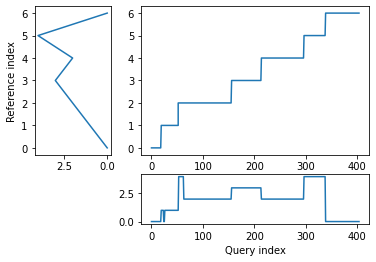

1/1 - 0s - loss: 0.2710 - accuracy: 0.8938
[Before DTW] Before_DTW_Norm_20 
               precision    recall  f1-score   support

         sit       0.98      0.94      0.96        90
sit-to-stand       0.75      0.92      0.83        26
        walk       1.00      0.83      0.91       212
        turn       0.86      1.00      0.93        50
stand-to-sit       0.52      1.00      0.68        27

    accuracy                           0.89       405
   macro avg       0.82      0.94      0.86       405
weighted avg       0.93      0.89      0.90       405

------------------------------

[After DTW] After_DTW_Norm_20 
               precision    recall  f1-score   support

         sit       1.00      0.93      0.97        90
sit-to-stand       0.76      1.00      0.87        26
        walk       1.00      0.88      0.94       212
        turn       0.86      1.00      0.93        50
stand-to-sit       0.64      1.00      0.78        27

    accuracy                           0.92 

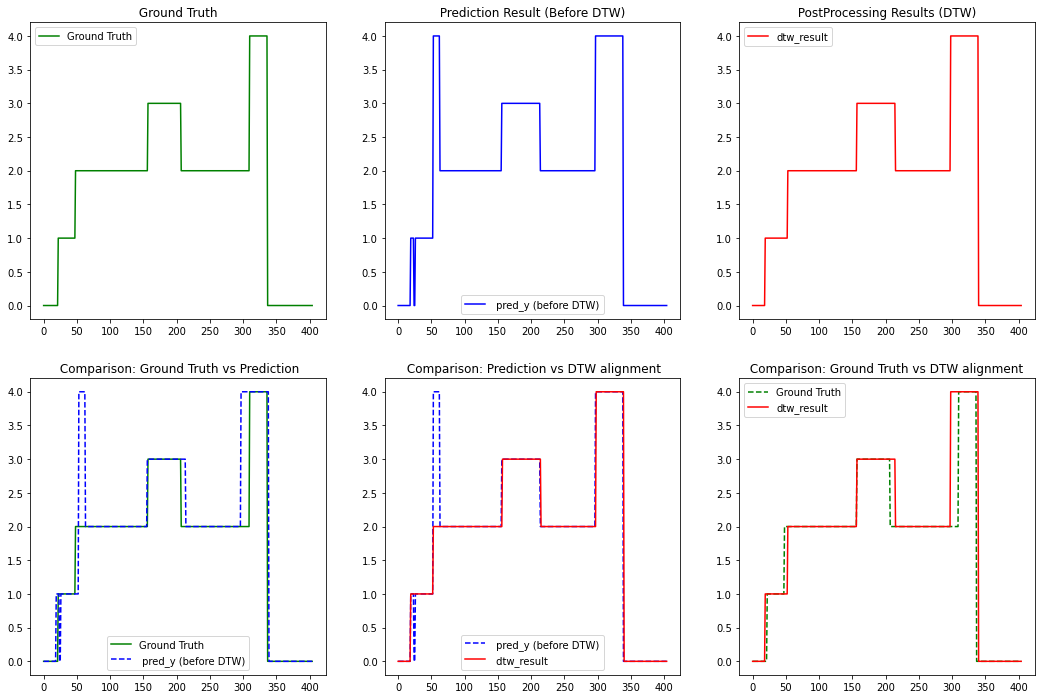

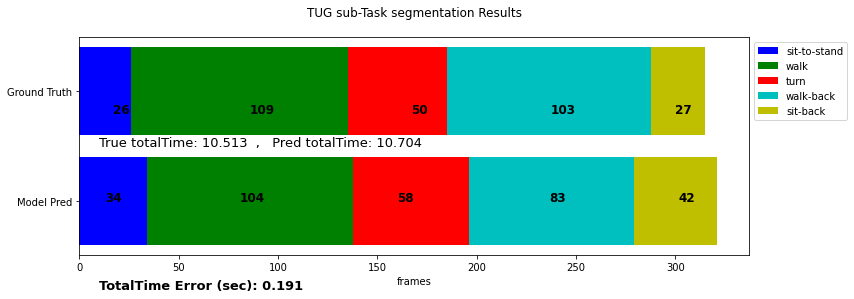

In [31]:
test_normal_20 = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/norm20/jek/02/Originact5_lpf_labeled_jek_02.csv"
test_normal_20_time, test_normal_20_x, test_normal_20_y_onehot = create_testdata(test_normal_20) 
test_normal_20_y = np.argmax(test_normal_20_y_onehot, axis=1).reshape(-1) # GND one-hot decode

pred_normal_20_y_onehot = model.predict(test_normal_20_x) 
pred_normal_20_y = np.argmax(pred_normal_20_y_onehot, axis=1) #  # pred one-hot decode

title = "normal_20"
normal_20_alignment, normal_20_results, true_subTask_frame_20, true_totalTime_20, pred_subTask_frame_20, pred_totalTime_20 = post_process_DTW(test_normal_20_time, test_normal_20_y, pred_normal_20_y, answer_y, title = title)

# --------------- DTW Result Visualization ------------------------ #
normal_20_alignment.plot(type="threeway")
plot_postResults(test_normal_20_y, pred_normal_20_y, normal_20_results, title = title)
norm_20_eval = model.evaluate(test_normal_20_x, test_normal_20_y_onehot, batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_Norm_20.txt",'w+t')
print("[Before DTW] Before_DTW_Norm_20 \n", classification_report(test_normal_20_y, pred_normal_20_y, target_names=target_names), file = report_dtw)
print("------------------------------\n", file = report_dtw)
print("[After DTW] After_DTW_Norm_20 \n", classification_report(test_normal_20_y, normal_20_results, target_names=target_names), file = report_dtw)
report_dtw.close()

# # ----------- Visualize in cell
print("[Before DTW] Before_DTW_Norm_20 \n", classification_report(test_normal_20_y, pred_normal_20_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After_DTW_Norm_20 \n", classification_report(test_normal_20_y, normal_20_results, target_names=target_names))


print(" [True]", true_subTask_frame_20, true_totalTime_20,"\n [Pred]", pred_subTask_frame_20, pred_totalTime_20) 
barplot_splitResults(pred_subTask_frame_20, true_subTask_frame_20,pred_totalTime_20, true_totalTime_20, title=title)

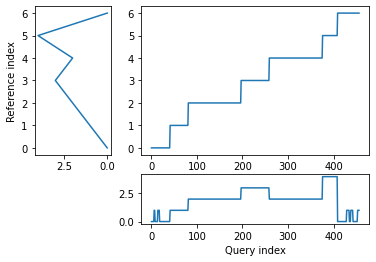

1/1 - 0s - loss: 0.3048 - accuracy: 0.8796
[Before DTW] Before_DTW_Norm_30 
               precision    recall  f1-score   support

         sit       0.96      0.71      0.82        91
sit-to-stand       0.52      1.00      0.69        32
        walk       0.94      0.94      0.94       233
        turn       0.95      0.82      0.88        72
stand-to-sit       0.79      0.90      0.84        29

    accuracy                           0.88       457
   macro avg       0.83      0.87      0.83       457
weighted avg       0.91      0.88      0.88       457

------------------------------

[After DTW] After_DTW_Norm_30 
               precision    recall  f1-score   support

         sit       0.97      0.95      0.96        91
sit-to-stand       0.80      1.00      0.89        32
        walk       0.94      0.94      0.94       233
        turn       0.95      0.82      0.88        72
stand-to-sit       0.79      0.90      0.84        29

    accuracy                           0.93 

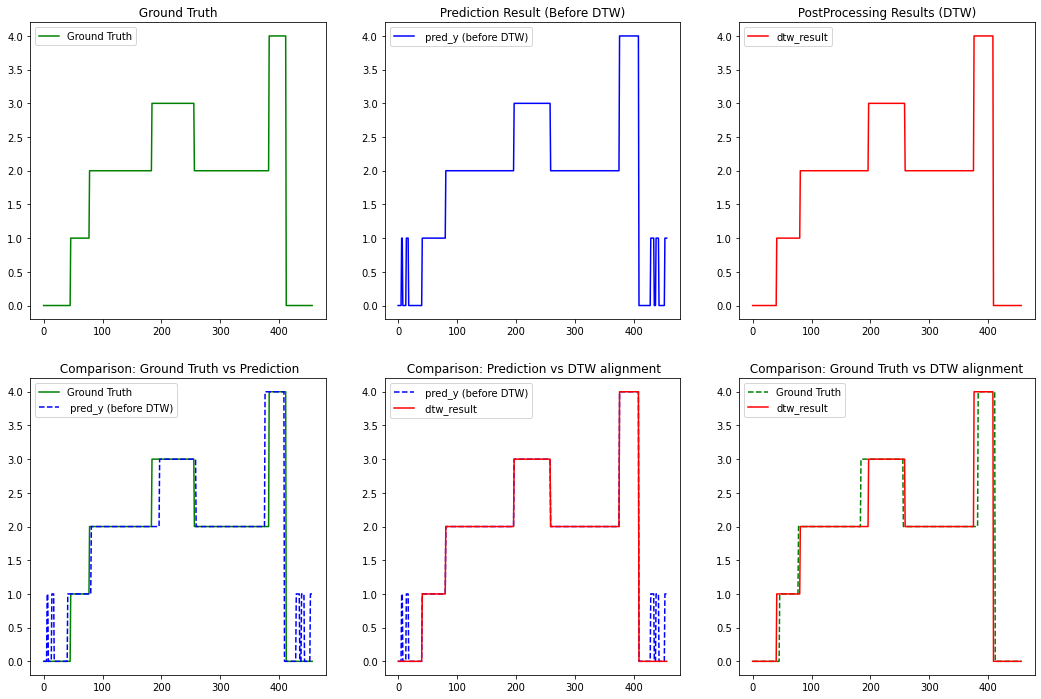

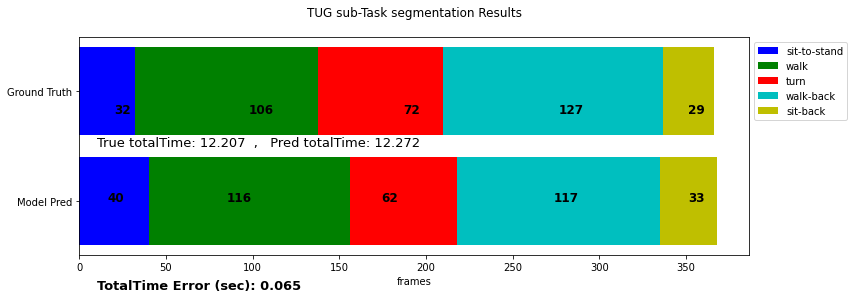

In [32]:
test_normal_30 = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/norm20/jdh/03/Originact5_lpf_labeled_jdh_03.csv"
test_normal_30_time, test_normal_30_x, test_normal_30_y_onehot = create_testdata(test_normal_30) 
test_normal_30_y = np.argmax(test_normal_30_y_onehot, axis=1).reshape(-1) # one-hot decode

pred_normal_30_onehot = model.predict(test_normal_30_x)
pred_normal_30_y = np.argmax(pred_normal_30_onehot, axis=1)

title = "normal_30"
normal_30_alignment, normal_30_results,  true_subTask_frame_30, true_totalTime_30, pred_subTask_frame_30, pred_totalTime_30 = post_process_DTW(test_normal_30_time, test_normal_30_y, pred_normal_30_y, answer_y, title=title)

# --------------- DTW Result Visualization ------------------------ #
normal_30_alignment.plot(type="threeway")
plot_postResults(test_normal_30_y, pred_normal_30_y, normal_30_results, title=title)
norm_30_eval = model.evaluate(test_normal_30_x, test_normal_30_y_onehot,batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_Norm_30.txt",'w+t')
print("[Before DTW] Before_DTW_Norm_30 \n", classification_report(test_normal_30_y, pred_normal_30_y, target_names=target_names), file = report_dtw)
print("------------------------------\n", file = report_dtw)
print("[After DTW] After_DTW_Norm_30 \n", classification_report(test_normal_30_y, normal_30_results, target_names=target_names), file = report_dtw)
report_dtw.close()

# # ----------- Visualize in cell
print("[Before DTW] Before_DTW_Norm_30 \n", classification_report(test_normal_30_y, pred_normal_30_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After_DTW_Norm_30 \n", classification_report(test_normal_30_y, normal_30_results, target_names=target_names))

print(" [True]", true_subTask_frame_30, true_totalTime_30,"\n [Pred]", pred_subTask_frame_30, pred_totalTime_30) 
barplot_splitResults(pred_subTask_frame_30, true_subTask_frame_30, pred_totalTime_30,true_totalTime_30, title=title)

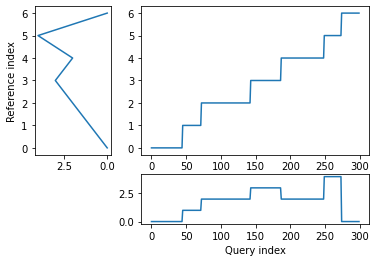

1/1 - 0s - loss: 0.2108 - accuracy: 0.9167
[Before DTW] Before DTW Norm 60 
               precision    recall  f1-score   support

         sit       1.00      0.85      0.92        84
sit-to-stand       0.70      1.00      0.83        19
        walk       0.95      0.96      0.95       131
        turn       0.89      0.87      0.88        45
stand-to-sit       0.80      0.95      0.87        21

    accuracy                           0.92       300
   macro avg       0.87      0.93      0.89       300
weighted avg       0.93      0.92      0.92       300

------------------------------

[After DTW] After_DTW_Norm_60 
               precision    recall  f1-score   support

         sit       1.00      0.85      0.92        84
sit-to-stand       0.70      1.00      0.83        19
        walk       0.95      0.96      0.95       131
        turn       0.89      0.87      0.88        45
stand-to-sit       0.80      0.95      0.87        21

    accuracy                           0.92 

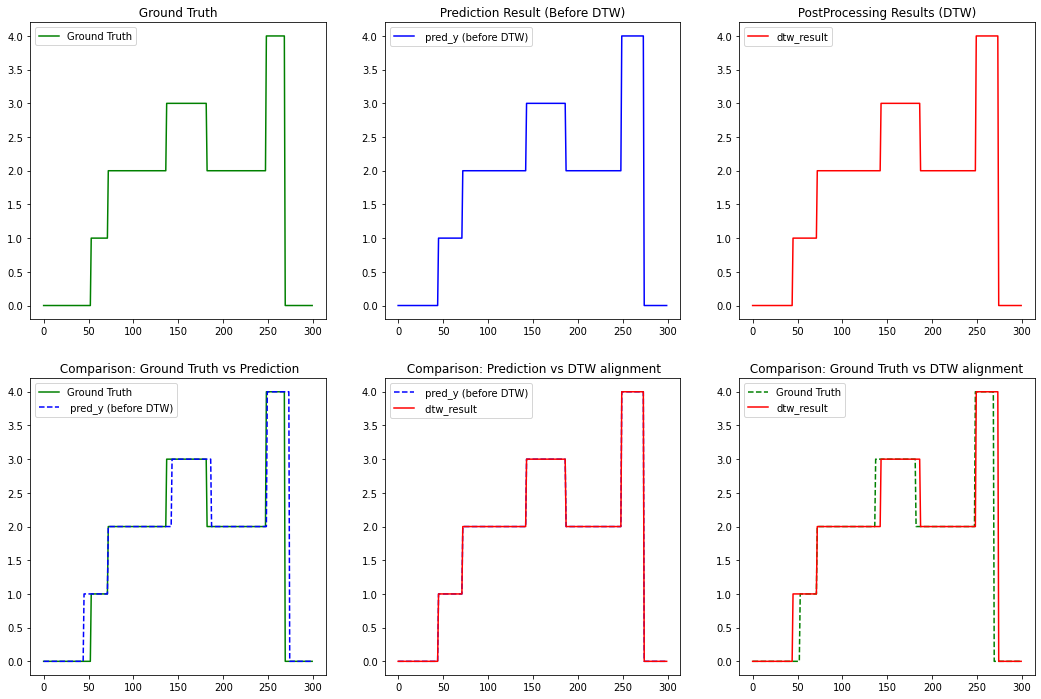

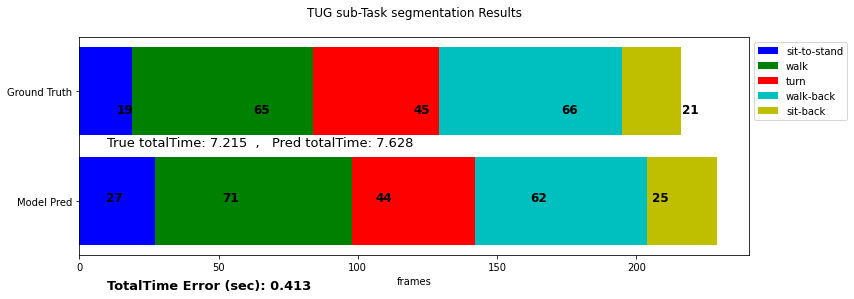

In [33]:
# test_normal_60 = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2021_02_09 TUG/UMS_TUG/05/Originact5_lpf_labeled_UMS_TUG_05.csv"
test_normal_60 = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/norm60/LBL_TUG/05/Originact5_lpf_labeled_LBL_TUG_05.csv"
test_normal_60_time, test_normal_60_x, test_normal_60_y_onehot = create_testdata(test_normal_60) 
test_normal_60_y = np.argmax(test_normal_60_y_onehot, axis=1).reshape(-1) # one-hot decode


pred_normal_60_onehot = model.predict(test_normal_60_x)
pred_normal_60_y = np.argmax(pred_normal_60_onehot, axis=1).reshape(-1) 

title = "normal_60"
normal_60_alignment, normal_60_results, true_subTask_frame_60, true_totalTime_60, pred_subTask_frame_60, pred_totalTime_60 = post_process_DTW(test_normal_60_time, test_normal_60_y, pred_normal_60_y, answer_y, title=title)


# --------------- DTW Result Visualization ------------------------ #
normal_60_alignment.plot(type="threeway")
plot_postResults(test_normal_60_y, pred_normal_60_y, normal_60_results, title=title)
norm_60_eval = model.evaluate(test_normal_60_x, test_normal_60_y_onehot, batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_Norm_60.txt",'w+t')
print("[Before DTW] Before DTW Norm 60 \n", classification_report(test_normal_60_y, pred_normal_60_y, target_names=target_names), file = report_dtw)
print("------------------------------\n",file = report_dtw)
print("[After DTW] After_DTW_Norm_60 \n", classification_report(test_normal_60_y, normal_60_results, target_names=target_names), file =   report_dtw)
report_dtw.close()

# ----------- Visualize in cell
print("[Before DTW] Before DTW Norm 60 \n", classification_report(test_normal_60_y, pred_normal_60_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After_DTW_Norm_60 \n", classification_report(test_normal_60_y, normal_60_results, target_names=target_names))

print(" [True]", true_subTask_frame_60, true_totalTime_60,"\n [Pred]", pred_subTask_frame_60, pred_totalTime_60) 
barplot_splitResults(pred_subTask_frame_60, true_subTask_frame_60, pred_totalTime_60, true_totalTime_60, title=title)

###  Stroke -- 보조필요 없는 수준의 편마비, 케인/지팡이 사용,  모방 보행

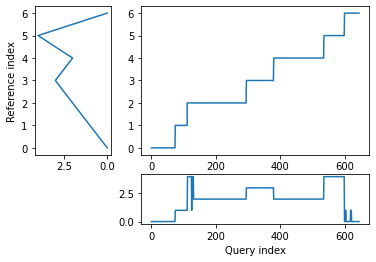

2/2 - 0s - loss: 0.3291 - accuracy: 0.8746
[Before DTW] Before DTW stroke_1 
               precision    recall  f1-score   support

         sit       0.92      0.96      0.94       110
sit-to-stand       0.86      0.83      0.84        46
        walk       0.94      0.87      0.90       349
        turn       0.93      0.81      0.87        97
stand-to-sit       0.49      0.91      0.63        44

    accuracy                           0.87       646
   macro avg       0.83      0.88      0.84       646
weighted avg       0.90      0.87      0.88       646

------------------------------

[After DTW] After DTW stroke_1 
               precision    recall  f1-score   support

         sit       0.92      1.00      0.96       110
sit-to-stand       1.00      0.83      0.90        46
        walk       0.94      0.91      0.93       349
        turn       0.92      0.80      0.86        97
stand-to-sit       0.64      0.93      0.76        44

    accuracy                           0.9

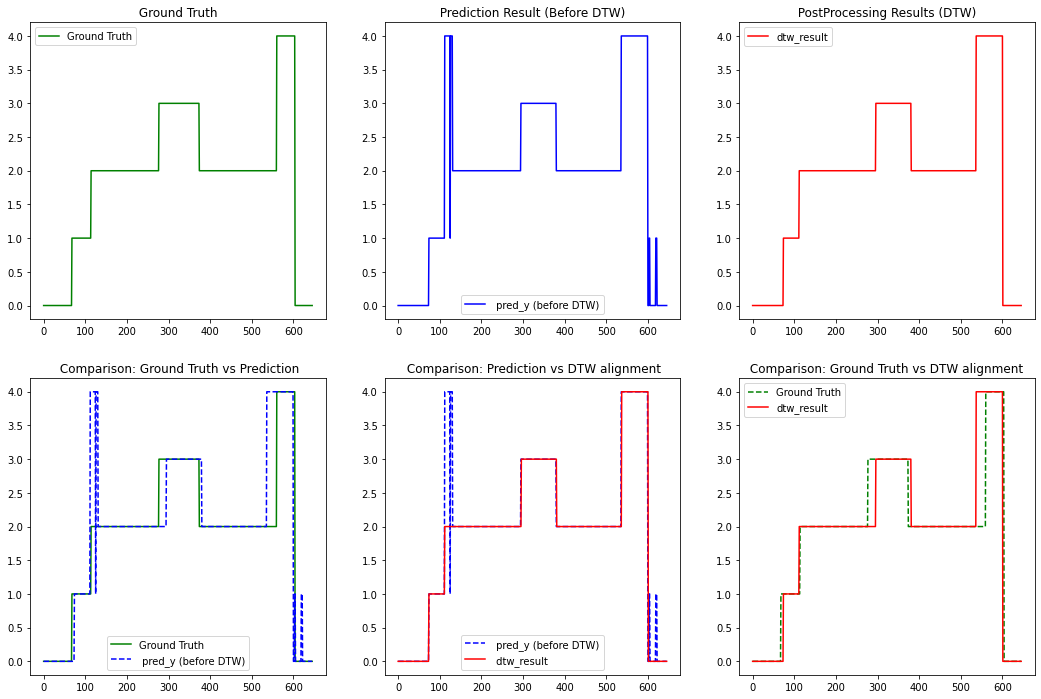

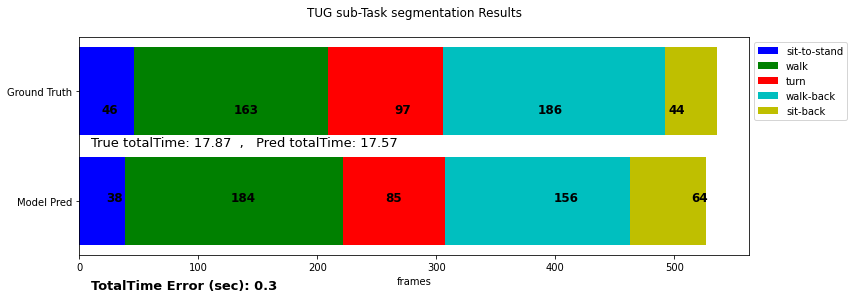

In [34]:
# test_stroke_1 =  "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/stroke/JDW_tug/01/Originact5_lpf_labeled_JDW_tug_01.csv"
test_stroke_1 = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/stroke/SHW_TUG/04/Originact5_lpf_labeled_SHW_TUG_04.csv"
test_normal_stroke_time, test_stroke_1_x, test_stroke_1_y_onehot = create_testdata(test_stroke_1)  
test_stroke_1_y = np.argmax(test_stroke_1_y_onehot, axis=1).reshape(-1) # one-hot decode

pred_stroke_1_one_hot = model.predict(test_stroke_1_x)
pred_stroke_1_y = np.argmax(pred_stroke_1_one_hot, axis=1)

title="stroke_1"
stroke_1_alignment, stroke_1_results, true_subTask_frame_stroke, true_totalTime_stroke, pred_subTask_frame_stroke, pred_totalTime_stroke = post_process_DTW(test_normal_stroke_time, test_stroke_1_y, pred_stroke_1_y, answer_y,  title=title)


# --------------- DTW Result Visualization ------------------------ #
stroke_1_alignment.plot(type="threeway")
plot_postResults(test_stroke_1_y, pred_stroke_1_y, stroke_1_results, title=title)
stroke_1_eval = model.evaluate(test_stroke_1_x, test_stroke_1_y_onehot, batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_stroke_1.txt",'w+t')
print("[Before DTW] Before DTW stroke_1 \n", classification_report(test_stroke_1_y, pred_stroke_1_y, target_names=target_names), file = report_dtw)
print("------------------------------\n", file = report_dtw)
print("[After DTW] After DTW stroke_1 \n", classification_report(test_stroke_1_y, stroke_1_results, target_names=target_names), file = report_dtw)
report_dtw.close()

# # ----------- Visualize in cell
print("[Before DTW] Before DTW stroke_1 \n", classification_report(test_stroke_1_y, pred_stroke_1_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After DTW stroke_1 \n", classification_report(test_stroke_1_y, stroke_1_results, target_names=target_names))

print(" [True]", true_subTask_frame_stroke, true_totalTime_stroke,"\n [Pred]", pred_subTask_frame_stroke, pred_totalTime_stroke) 
barplot_splitResults(pred_subTask_frame_stroke, true_subTask_frame_stroke, pred_totalTime_stroke, true_totalTime_stroke, title=title)

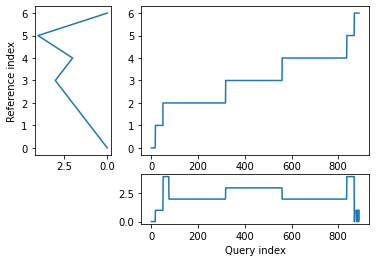

2/2 - 0s - loss: 0.3716 - accuracy: 0.8820
[Before DTW] Before DTW stroke_tool 
               precision    recall  f1-score   support

         sit       0.92      0.64      0.75        36
sit-to-stand       0.59      0.71      0.64        38
        walk       0.93      0.93      0.93       523
        turn       0.96      0.87      0.91       268
stand-to-sit       0.30      0.68      0.41        25

    accuracy                           0.88       890
   macro avg       0.74      0.77      0.73       890
weighted avg       0.91      0.88      0.89       890

------------------------------
 
[After DTW] After DTW stroke_tool 
               precision    recall  f1-score   support

         sit       0.81      0.83      0.82        36
sit-to-stand       0.82      0.71      0.76        38
        walk       0.91      0.95      0.93       523
        turn       0.96      0.87      0.91       268
stand-to-sit       0.56      0.72      0.63        25

    accuracy                       

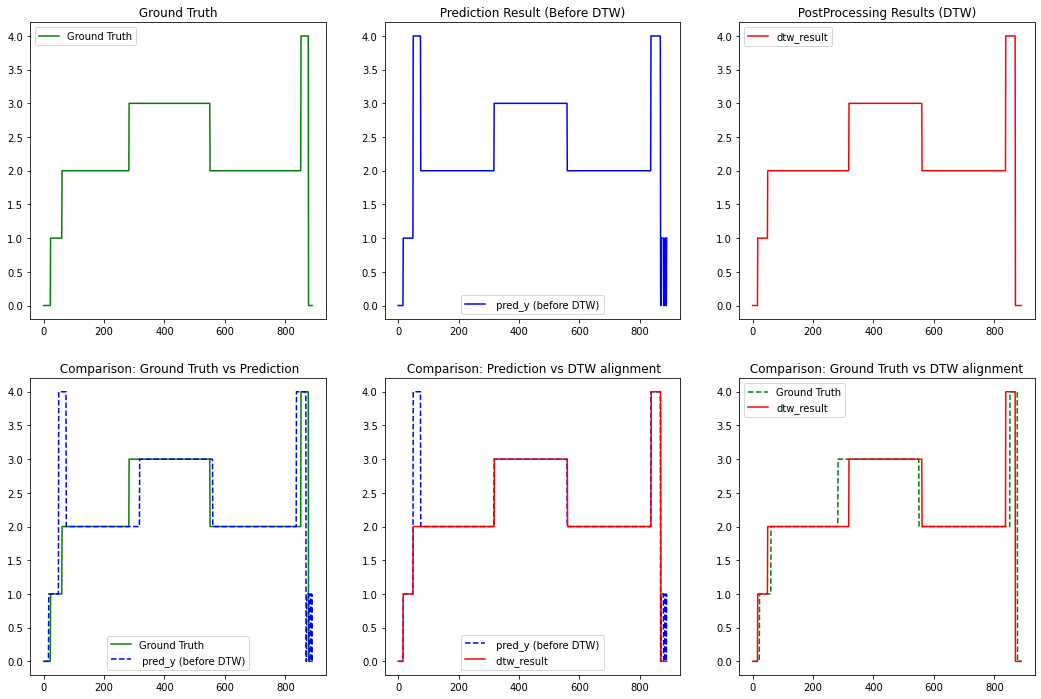

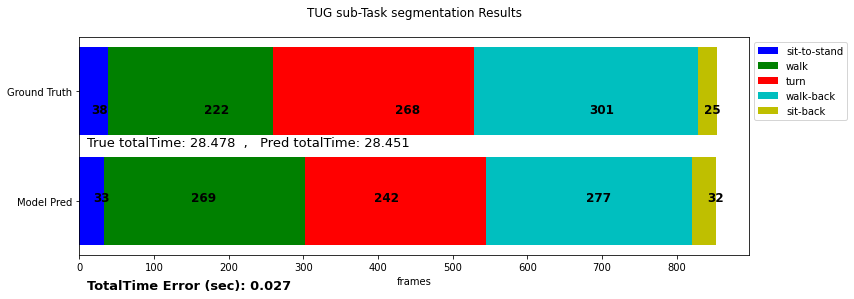

In [35]:
test_stroke_tool = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/HMM_saveResults_illness_CYJ/0_sideView/stroke/KNG_TUG/03/Originact5_lpf_labeled_KNG_TUG_03.csv"
test_stroke_tool_time, test_stroke_tool_x, test_stroke_tool_y_onehot = create_testdata(test_stroke_tool) 
test_stroke_tool_y = np.argmax(test_stroke_tool_y_onehot, axis=1).reshape(-1) #one-hot decode

pred_stroke_tool_onehot = model.predict(test_stroke_tool_x)
pred_stroke_tool_y = np.argmax(pred_stroke_tool_onehot, axis=1)

title = "stroke_tool"
stroke_tool_alignment, stroke_tool_results, true_subTask_frame_stroke_tool, true_totalTime_stroke_tool, pred_subTask_frame_stroke_tool, pred_totalTime_stroke_tool = post_process_DTW(test_stroke_tool_time, test_stroke_tool_y, pred_stroke_tool_y, answer_y, title=title)


# --------------- DTW Result Visualization ------------------------ #
stroke_tool_alignment.plot(type="threeway")
plot_postResults(test_stroke_tool_y, pred_stroke_tool_y, stroke_tool_results, title=title)
stroke_tool_eval = model.evaluate(test_stroke_tool_x, test_stroke_tool_y_onehot,batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_stroke_tool.txt",'w+t')
print("[Before DTW] Before DTW stroke_tool \n", classification_report(test_stroke_tool_y, pred_stroke_tool_y, target_names=target_names), file = report_dtw)
print("------------------------------\n ", file = report_dtw)
print("[After DTW] After DTW stroke_tool \n", classification_report(test_stroke_tool_y, stroke_tool_results, target_names=target_names), file = report_dtw)
report_dtw.close()

# # ----------- Visualize in cell
print("[Before DTW] Before DTW stroke_tool \n", classification_report(test_stroke_tool_y, pred_stroke_tool_y, target_names=target_names))
print("------------------------------\n ")
print("[After DTW] After DTW stroke_tool \n", classification_report(test_stroke_tool_y, stroke_tool_results, target_names=target_names))

print(" [True]", true_subTask_frame_stroke_tool, true_totalTime_stroke_tool,"\n [Pred]", pred_subTask_frame_stroke_tool, pred_totalTime_stroke_tool) 
barplot_splitResults(pred_subTask_frame_stroke_tool, true_subTask_frame_stroke_tool, pred_totalTime_stroke_tool, true_totalTime_stroke_tool, title=title)

In [36]:
# os.rename(MODEL_SAVE_FOLDER_PATH, MODEL_SAVE_FOLDER_PATH + "_loss-" + str(np.round(eval_result[1],4)))
src = "/DockerProjects/walkCAM/tug/temporalCNN_wLabel/Results/" +  selected_LPF + expertFolder +"/" + str(selected_type) +"_P" +str(patience)+"_" + ModelTime 
dst = "/DockerProjects/walkCAM/tug/temporalCNN_wLabel/Results/" + selected_LPF + expertFolder +"/" + str(selected_type) +"_P" +str(patience)+"_" + ModelTime + "_loss-" + str(np.round(eval_result[1],4))
print(dst)
os.rename(src, dst)

/DockerProjects/walkCAM/tug/temporalCNN_wLabel/Results/LPF_C3_5_O4/LSTM2HMM_saveResults_illness_KYH/norm60_P15_20210516-20h12m_loss-0.9266


In [19]:
# Valid loss < Train loss  설명https://koreapy.tistory.com/577